In [79]:
'''This script is used to train a linear regression model with the second training scheme I'm considering; the 
one that uses all previous data and aggregated yearly metrics for each beneficiary year.'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import (LinearRegression
)
from sklearn.preprocessing import (
    OneHotEncoder, TargetEncoder
)
from utils import (
    describe_dataframe, df_train_test, graph_results, reg_train_eval
)

In [63]:
main = pd.read_csv("../data/combo_data.csv")
main

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,YR,LOS,DRG,PRNCPAL_DGNS_CD,PTNT_DSCHRG_STUS_CD,CLM_IP_ADMSN_TYPE_CD,...,NUM_DIAG,ICD_Description,DRG_TITLE,STATE_CODE,COUNTY_CD,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT
0,-10000010254618,-10000930037831,2015-03-25,2015-03-25,2015,0,551,S134XX,1,1,...,9,Sprain of ligaments of cervical spine,MEDICAL BACK PROBLEMS WITH MCC,1,1500,1,1,0,16,275.19
1,-10000010254653,-10000930038030,2015-09-24,2015-09-24,2015,0,951,Z3480,1,1,...,4,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1400,2,1,0,33,0.00
2,-10000010254653,-10000930038031,2017-05-09,2017-05-10,2017,1,923,T7432X,1,3,...,3,"Child psychological abuse, confirmed","OTHER INJURY, POISONING AND TOXIC EFFECT DIAGN...",1,1400,2,1,0,35,0.00
3,-10000010254656,-10000930038162,2017-01-14,2017-01-14,2017,0,564,S8290X,1,1,...,4,Unspecified fracture of unspecified lower leg,OTHER MUSCULOSKELETAL SYSTEM AND CONNECTIVE TI...,1,1360,2,1,0,18,302.04
4,-10000010254656,-10000930038163,2018-03-17,2018-03-17,2018,0,951,Z3480,1,1,...,6,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1360,2,1,0,19,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,-10000010288008,-10000931485965,2020-01-08,2020-01-14,2020,6,0,T50901A,1,3,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20863,-10000010288008,-10000931485967,2020-10-23,2020-10-23,2020,0,0,T50901A,1,1,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20864,-10000010288008,-10000931485969,2021-08-22,2021-08-23,2021,1,0,T50901A,1,1,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00
20865,-10000010288008,-10000931485971,2021-09-13,2021-09-16,2021,3,0,T50901A,1,2,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00


In [64]:
describe_dataframe(main)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,BENE_ID,int64,20867,0,5699,"[-10000010254618, -10000010254653, -1000001025...",-10000010288010,-10000010254618,-10000010270649.408203
1,CLM_ID,int64,20867,0,20867,"[-10000930037831, -10000930038030, -1000093003...",-10000931486024,-10000930037831,-10000930747721.667969
2,CLM_FROM_DT,object,20867,0,2914,"[2015-03-25, 2015-09-24, 2017-05-09, 2017-01-1...",None,None,None
3,CLM_THRU_DT,object,20867,0,2910,"[2015-03-25, 2015-09-24, 2017-05-10, 2017-01-1...",None,None,None
4,YR,int64,20867,0,9,"[2015, 2017, 2018, 2022, 2021]",2015,2023,2019.100014
5,LOS,int64,20867,0,45,"[0, 1, 10, 11, 2]",0,104,1.054919
6,DRG,int64,20867,0,168,"[551, 951, 923, 564, 101]",0,976,662.292088
7,PRNCPAL_DGNS_CD,object,20867,0,190,"[S134XX, Z3480, T7432X, S8290X, Z3400]",None,None,None
8,PTNT_DSCHRG_STUS_CD,int64,20867,0,1,[1],1,1,1.0
9,CLM_IP_ADMSN_TYPE_CD,int64,20867,0,3,"[1, 3, 2]",1,3,1.399195


In [65]:
#Have to aggregate certain columns by beneficiary, over the years
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

In [66]:
main.columns
workingdf = main[select_cols]

severe_codes = workingdf.loc[workingdf["LOS"] > 10, "PRNCPAL_DGNS_CD"].unique()
workingdf = workingdf.assign(SEV_FLAG=np.where(workingdf["PRNCPAL_DGNS_CD"].isin(severe_codes), 1, 0))
#Have to use severity flag (which could be determined in many ways) instead of PRCNPAL_DGNS_CD because PRNCP can't be used with regression
workingdf = workingdf.assign(ESRD_IND = workingdf["ESRD_IND"].map({"Y": 1, "0" : 0}))

workingdf = workingdf.drop(columns=["PRNCPAL_DGNS_CD"])

describe_dataframe(workingdf)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,LOS,int64,20867,0,45,"[0, 1, 10, 11, 2]",0.0,104.00,1.054919
1,YR,int64,20867,0,9,"[2015, 2017, 2018, 2022, 2021]",2015.0,2023.00,2019.100014
2,CLM_IP_ADMSN_TYPE_CD,int64,20867,0,3,"[1, 3, 2]",1.0,3.00,1.399195
3,ER_flag,int64,20867,0,2,"[0, 1]",0.0,1.00,0.048498
4,STATE_CODE,int64,20867,0,51,"[1, 2, 3, 4, 6]",1.0,53.00,24.974553
5,COUNTY_CD,int64,20867,0,1350,"[1500, 1400, 1360, 1440, 1120]",1010.0,53220.00,25327.166339
6,BENE_RACE_CD,int64,20867,0,6,"[1, 4, 2, 5, 3]",1.0,6.00,2.049456
7,ESRD_IND,int64,20867,0,2,"[0, 1]",0.0,1.00,0.163943
8,Age,int64,20867,0,112,"[16, 33, 35, 18, 19]",0.0,111.00,66.288015
9,TOT_RX_CST_AMT,float64,20867,0,7231,"[275.19, 0.0, 302.04, 444.23, 408.33]",0.0,197011.98,11439.025583


In [67]:
workingdf['YR'].unique()

array([2015, 2017, 2018, 2022, 2021, 2020, 2023, 2016, 2019])

In [68]:
type(workingdf['YR'][1])

numpy.int64

In [69]:
# I thought about one hot encoding the data in a data_processing script, but I think the flexibility of being able
# to tailor the encoding approach each time is important, and it makes it easier to see how I encoded the data
# from previous train-test runs if I keep that process contained in this notebook instead of having it hidden in 
# a seperate script somewhere else

#Need to divide up the data into training and testing sets by year
wdf_rest = workingdf[workingdf["YR"] < 2022]
wdf_2023 = workingdf[workingdf["YR"] >= 2022]

#one hot encode state, race, admission type, sex, 
ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_rest = pd.DataFrame(data = ohe.transform(wdf_rest[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2023[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2023 = pd.DataFrame(data = ohe.transform(wdf_2023[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2023[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
wdf_rest = wdf_rest.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
wdf_2023 = wdf_2023.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

wdf_rest = pd.concat([wdf_rest.reset_index(drop=True), ohe_df_rest.reset_index(drop=True)], axis=1)
wdf_2023 = pd.concat([wdf_2023.reset_index(drop=True), ohe_df_2023.reset_index(drop=True)], axis=1)

In [70]:
describe_dataframe(wdf_rest)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,LOS,int64,16800,0,43,"[0, 1, 10, 11, 2]",0.0,104.00,1.045655
1,ER_flag,int64,16800,0,2,"[0, 1]",0.0,1.00,0.049524
2,ESRD_IND,int64,16800,0,2,"[0, 1]",0.0,1.00,0.156548
3,Age,int64,16800,0,110,"[16, 33, 35, 18, 19]",0.0,109.00,65.523869
4,TOT_RX_CST_AMT,float64,16800,0,5978,"[275.19, 0.0, 302.04, 444.23, 408.33]",0.0,197011.98,11687.577937
...,...,...,...,...,...,...,...,...,...
64,BENE_RACE_CD_4,float64,16800,0,2,"[0.0, 1.0]",0.0,1.00,0.035119
65,BENE_RACE_CD_5,float64,16800,0,2,"[0.0, 1.0]",0.0,1.00,0.183393
66,BENE_RACE_CD_6,float64,16800,0,2,"[0.0, 1.0]",0.0,1.00,0.010774
67,SEX_IDENT_CD_1,float64,16800,0,2,"[1.0, 0.0]",0.0,1.00,0.546786


In [71]:
describe_dataframe(wdf_2023)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,LOS,int64,4067,0,30,"[0, 1, 2, 3, 6]",0.0,47.00,1.093189
1,ER_flag,int64,4067,0,2,"[0, 1]",0.0,1.00,0.044259
2,ESRD_IND,int64,4067,0,2,"[0, 1]",0.0,1.00,0.194492
3,Age,int64,4067,0,112,"[23, 75, 78, 79, 76]",0.0,111.00,69.444554
4,TOT_RX_CST_AMT,float64,4067,0,1340,"[0.0, 66502.74, 11638.01, 5687.32, 8287.1]",0.0,189898.08,10412.303297
...,...,...,...,...,...,...,...,...,...
64,BENE_RACE_CD_4,float64,4067,0,2,"[0.0, 1.0]",0.0,1.00,0.029014
65,BENE_RACE_CD_5,float64,4067,0,2,"[0.0, 1.0]",0.0,1.00,0.182198
66,BENE_RACE_CD_6,float64,4067,0,2,"[0.0, 1.0]",0.0,1.00,0.012294
67,SEX_IDENT_CD_1,float64,4067,0,2,"[0.0, 1.0]",0.0,1.00,0.554709


In [72]:
X_train_rest, X_test_rest, y_train_rest, y_test_rest = df_train_test(wdf_rest, "LOS", 0.2)

X_train_2023, X_test_2023, y_train_2023, y_test_2023 = df_train_test(wdf_2023, "LOS", 0.2)

In [73]:
describe_dataframe(X_train_rest)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,ER_flag,int64,13440,0,2,"[0, 1]",0.0,1.00,0.049033
1,ESRD_IND,int64,13440,0,2,"[0, 1]",0.0,1.00,0.156548
2,Age,int64,13440,0,110,"[49, 102, 48, 80, 52]",0.0,109.00,65.574777
3,TOT_RX_CST_AMT,float64,13440,0,5123,"[2981.2700000000004, 0.0, 1554.05, 2943.38, 1.18]",0.0,197011.98,11898.940080
4,NUM_DIAG,int64,13440,0,54,"[12, 13, 19, 11, 10]",1.0,55.00,21.513244
...,...,...,...,...,...,...,...,...,...
63,BENE_RACE_CD_4,float64,13440,0,2,"[0.0, 1.0]",0.0,1.00,0.034301
64,BENE_RACE_CD_5,float64,13440,0,2,"[0.0, 1.0]",0.0,1.00,0.185565
65,BENE_RACE_CD_6,float64,13440,0,2,"[0.0, 1.0]",0.0,1.00,0.010863
66,SEX_IDENT_CD_1,float64,13440,0,2,"[0.0, 1.0]",0.0,1.00,0.547173


In [ ]:
reg_mod_metrics = {"Test":{},
                   "Train":{}}

predictions = {}

#Always need to test on a future year because the training data has already been observed (and so testing on it
# gives you no new information, and is not a useful application).

#
reg_train_eval(LinearRegression(),
               None,
               X_train_rest,
               y_train_rest,
               X_test_2023,
               y_test_2023,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2023test")



0.3600572124500635

In [75]:
reg_mod_metrics

{'Test': {'LinearRegression - NoneType - rest_train-2023test': {'RMSLE': 0.45243282611375374,
   'R2': 0.3600572124500635,
   'MAE': 1.071987453311116,
   'MSE': 8.456505768259749}},
 'Train': {'LinearRegression - NoneType - rest_train-2023test': {'RMSLE': 0.4429241478502226,
   'R2': 0.38289019428102744,
   'MAE': 0.9741543625881669,
   'MSE': 5.822642216470609}}}

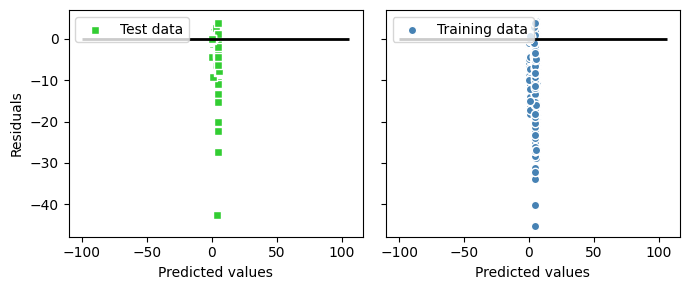

In [76]:
# Graph results

graph_results(predictions["LinearRegression - NoneType - rest_train-2023test"]["y_predict_train"], 
              predictions["LinearRegression - NoneType - rest_train-2023test"]["y_predict"], 
              y_train_rest, 
              y_test_2023)

In [81]:
"""unique_diagnosis_codes = workingdf_te['PRNCPAL_DGNS_CD'].unique()

# Create a histogram for each diagnosis code
for code in unique_diagnosis_codes:
    subset = workingdf_te[workingdf_te['PRNCPAL_DGNS_CD'] == code]
    plt.figure(figsize=(8, 6))
    plt.hist(subset['LOS'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of LOS for Diagnosis Code: {code}')
    plt.xlabel('Length of Stay (LOS)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()"""

#The above plots showed that there were a lot of diagnosis codes for which the average LOS actually was 0

"unique_diagnosis_codes = workingdf_te['PRNCPAL_DGNS_CD'].unique()\n\n# Create a histogram for each diagnosis code\nfor code in unique_diagnosis_codes:\n    subset = workingdf_te[workingdf_te['PRNCPAL_DGNS_CD'] == code]\n    plt.figure(figsize=(8, 6))\n    plt.hist(subset['LOS'], bins=20, alpha=0.7, color='blue', edgecolor='black')\n    plt.title(f'Histogram of LOS for Diagnosis Code: {code}')\n    plt.xlabel('Length of Stay (LOS)')\n    plt.ylabel('Frequency')\n    plt.grid(axis='y', alpha=0.75)\n    plt.show()"

In [138]:
# Target Encoding Diagnosis Codes

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te

(20867, 1)
(20867,)


,LOS,YR,PRNCPAL_DGNS_CD,CLM_IP_ADMSN_TYPE_CD,ER_flag,STATE_CODE,COUNTY_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT,NUM_DIAG,SEX_IDENT_CD
0,0,2015,0.031124,1,0,1,1500,1,0,16,275.19,9,1
1,0,2015,0.079185,1,0,1,1400,1,0,33,0.00,4,2
2,1,2017,0.040749,3,0,1,1400,1,0,35,0.00,3,2
3,0,2017,0.049329,1,0,1,1360,1,0,18,302.04,4,2
4,0,2018,0.079185,1,0,1,1360,1,0,19,0.00,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,6,2020,3.616582,3,0,5,5430,5,0,75,0.00,12,1
20863,0,2020,3.616582,1,0,5,5430,5,0,75,0.00,12,1
20864,1,2021,3.671200,1,1,5,5430,5,0,76,0.00,13,1
20865,3,2021,3.575752,2,0,5,5430,5,0,76,0.00,13,1


In [139]:
workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2023_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2023_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2023_te = pd.DataFrame(data = ohe.transform(wdf_2023_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2023_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
wdf_2023_te = wdf_2023_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

wdf_rest_te = pd.concat([wdf_rest_te.reset_index(drop=True), ohe_df_rest_te.reset_index(drop=True)], axis=1)
wdf_2023_te = pd.concat([wdf_2023_te.reset_index(drop=True), ohe_df_2023_te.reset_index(drop=True)], axis=1)

In [141]:
X_train_rest_te, X_test_rest_te, y_train_rest_te, y_test_rest_te = df_train_test(wdf_rest_te, "LOS", 0.2)

X_train_2023_te, X_test_2023_te, y_train_2023_te, y_test_2023_te = df_train_test(wdf_2023_te, "LOS", 0.2)

In [142]:
reg_train_eval(LinearRegression(),
               None,
               X_train_rest_te,
               y_train_rest_te,
               X_test_2023_te,
               y_test_2023_te,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2023test_target_enc")

reg_mod_metrics

{'Test': {'LinearRegression - NoneType - rest_train-2023test': {'RMSLE': 0.45243282611375374,
   'R2': 0.3600572124500635,
   'MAE': 1.071987453311116,
   'MSE': 8.456505768259749},
  'LinearRegression - NoneType - rest_train-2023test_target_enc': {'RMSLE': 0.45930299455161216,
   'R2': 0.367184647716697,
   'MAE': 1.0120627832716216,
   'MSE': 8.36232047760909}},
 'Train': {'LinearRegression - NoneType - rest_train-2023test': {'RMSLE': 0.4429241478502226,
   'R2': 0.38289019428102744,
   'MAE': 0.9741543625881669,
   'MSE': 5.822642216470609},
  'LinearRegression - NoneType - rest_train-2023test_target_enc': {'RMSLE': 0.4435219409602578,
   'R2': 0.4370537043341285,
   'MAE': 0.8804036215743143,
   'MSE': 5.311590962212893}}}

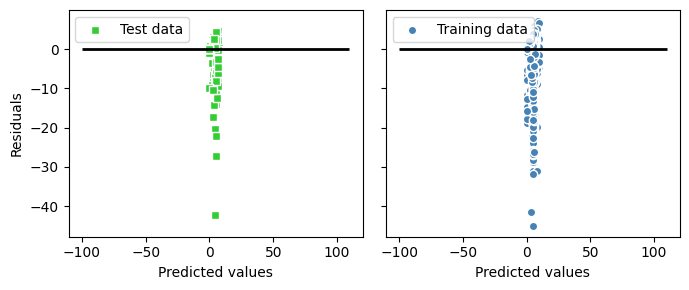

In [143]:
# Graph Results

graph_results(predictions["LinearRegression - NoneType - rest_train-2023test_target_enc"]["y_predict_train"], 
              predictions["LinearRegression - NoneType - rest_train-2023test_target_enc"]["y_predict"], 
              y_train_rest_te, 
              y_test_2023_te)